In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [9]:
df1 = pd.read_excel('../Apoyo-Desafio/ramen-ratings.xlsx')
df1.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [10]:
# Identificar valores faltantes
missing_values = df1.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

# Tratar valores faltantes
# En este caso, vamos a rellenar los valores faltantes en la columna 'Style' con 'Unknown'
df1['Style'].fillna('Unknown', inplace=True)

# Para la columna 'Top Ten', podemos rellenar los valores faltantes con 'No'
df1['Top Ten'].fillna('No', inplace=True)

# Verificar nuevamente los valores faltantes
missing_values_after = df1.isnull().sum()
print("\nValores faltantes después del tratamiento:")
print(missing_values_after)

# Identificar valores atípicos
# Vamos a convertir la columna 'Stars' a numérica para poder identificar valores atípicos
df1['Stars'] = pd.to_numeric(df1['Stars'], errors='coerce')

# Descripción estadística para identificar valores atípicos
print("\nDescripción estadística de la columna 'Stars':")
print(df1['Stars'].describe())

# Identificar valores atípicos usando el método IQR (Interquartile Range)
Q1 = df1['Stars'].quantile(0.25)
Q3 = df1['Stars'].quantile(0.75)
IQR = Q3 - Q1
outliers = df1[(df1['Stars'] < (Q1 - 1.5 * IQR)) | (df1['Stars'] > (Q3 + 1.5 * IQR))]
print("\nValores atípicos en la columna 'Stars':")
print(outliers)

# Tratar valores atípicos
# En este caso, vamos a eliminar los valores atípicos
df1 = df1[~((df1['Stars'] < (Q1 - 1.5 * IQR)) | (df1['Stars'] > (Q3 + 1.5 * IQR)))]

# Verificar nuevamente la descripción estadística después de eliminar valores atípicos
print("\nDescripción estadística de la columna 'Stars' después de eliminar valores atípicos:")
print(df1['Stars'].describe())

# Identificar y corregir errores en los datos
# Verificar valores únicos en la columna 'Country'
print("\nValores únicos en la columna 'Country':")
print(df1['Country'].unique())

# Si encontramos errores tipográficos en los nombres de los países, podemos corregirlos
# Por ejemplo, si encontramos 'USA ' en lugar de 'USA', podemos corregirlo así:
df1['Country'] = df1['Country'].str.strip()

# Verificar nuevamente los valores únicos en la columna 'Country'
print("\nValores únicos en la columna 'Country' después de la corrección:")
print(df1['Country'].unique())

# El conjunto de datos está limpio y preparado para su posterior procesamiento y entrenamiento de los modelos
print("\nEl conjunto de datos está limpio y preparado para su posterior procesamiento y entrenamiento de los modelos.")

Valores faltantes por columna:
Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64

Valores faltantes después del tratamiento:
Review #    0
Brand       0
Variety     0
Style       0
Country     0
Stars       0
Top Ten     0
dtype: int64

Descripción estadística de la columna 'Stars':
count    2577.000000
mean        3.654676
std         1.015331
min         0.000000
25%         3.250000
50%         3.750000
75%         4.250000
max         5.000000
Name: Stars, dtype: float64

Valores atípicos en la columna 'Stars':
      Review #          Brand  \
1         2579       Just Way   
8         2572     Ripe'n'Dry   
36        2544         Lipton   
38        2542        Acecook   
53        2527  Uni-President   
...        ...            ...   
2550        30          Myojo   
2570        10          Smack   
2573         7        Ve Wong   
2576         4        Wai Wai   
2579         1       Westbrae   



C:\Users\marti\AppData\Local\Temp\ipykernel_15852\3727602351.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Style'].fillna('Unknown', inplace=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_15852\3727602351.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [12]:

# Separar características y etiquetas
X = df1.drop(columns=['Stars'])
y = df1['Stars']

# Identificar columnas numéricas y categóricas
numeric_features = ['Review #']
categorical_features = ['Brand', 'Variety', 'Style', 'Country', 'Top Ten']

# Crear transformadores para las características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear un preprocesador que aplique los transformadores a las columnas correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar el preprocesador a los conjuntos de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("Preprocesamiento completado. Conjuntos de datos listos para el entrenamiento y prueba de modelos.")

Preprocesamiento completado. Conjuntos de datos listos para el entrenamiento y prueba de modelos.


In [14]:

# Convertir la variable objetivo en binaria (bueno/malo)
# Consideramos "bueno" si Stars >= 3.5, de lo contrario "malo"
y_binary = (y >= 3.5).astype(int)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Aplicar el preprocesador a los conjuntos de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Entrenar un modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Reporte de clasificación para Regresión Logística:")
print(classification_report(y_test, y_pred_log_reg))

# Entrenar un modelo de SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Reporte de clasificación para SVM:")
print(classification_report(y_test, y_pred_svm))

# Realizar una búsqueda de hiperparámetros para Regresión Logística
param_grid_log_reg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}
grid_search_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5)
grid_search_log_reg.fit(X_train, y_train)
print("Mejores hiperparámetros para Regresión Logística:")
print(grid_search_log_reg.best_params_)

# Realizar una búsqueda de hiperparámetros para SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
print("Mejores hiperparámetros para SVM:")
print(grid_search_svm.best_params_)

Reporte de clasificación para Regresión Logística:
              precision    recall  f1-score   support

           0       0.61      0.24      0.34       126
           1       0.78      0.95      0.86       365

    accuracy                           0.77       491
   macro avg       0.70      0.59      0.60       491
weighted avg       0.74      0.77      0.73       491

Reporte de clasificación para SVM:
              precision    recall  f1-score   support

           0       0.58      0.17      0.27       126
           1       0.77      0.96      0.85       365

    accuracy                           0.76       491
   macro avg       0.67      0.57      0.56       491
weighted avg       0.72      0.76      0.70       491



d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores hiperparámetros para Regresión Logística:
{'C': 0.1, 'solver': 'liblinear'}
Mejores hiperparámetros para SVM:
{'C': 1, 'kernel': 'rbf'}


Métricas para Regresión Logística:
Precisión: 0.7657841140529531
Recall: 0.947945205479452
F1-score: 0.8574969021065675
AUC-ROC: 0.593020221787345

Métricas para SVM:
Precisión: 0.7556008146639511
Recall: 0.9561643835616438
F1-score: 0.8533007334963325
AUC-ROC: 0.5653837790824092

Comparación de resultados:
Precisión - Regresión Logística: 0.7657841140529531 vs SVM: 0.7556008146639511
Recall - Regresión Logística: 0.947945205479452 vs SVM: 0.9561643835616438
F1-score - Regresión Logística: 0.8574969021065675 vs SVM: 0.8533007334963325
AUC-ROC - Regresión Logística: 0.593020221787345 vs SVM: 0.5653837790824092


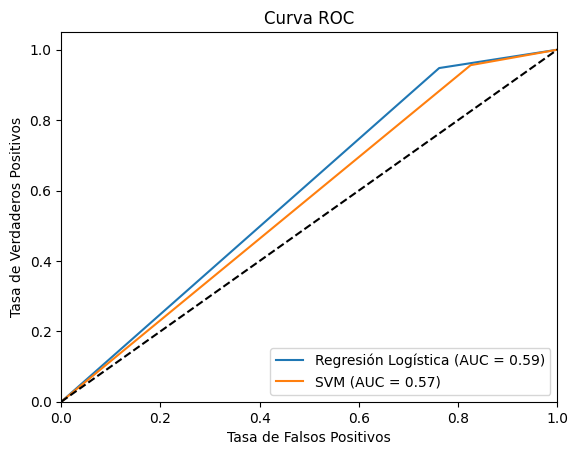

In [15]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

# Calcular métricas para Regresión Logística
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)

print("Métricas para Regresión Logística:")
print(f"Precisión: {accuracy_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"F1-score: {f1_log_reg}")
print(f"AUC-ROC: {roc_auc_log_reg}")

# Calcular métricas para SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

print("\nMétricas para SVM:")
print(f"Precisión: {accuracy_svm}")
print(f"Recall: {recall_svm}")
print(f"F1-score: {f1_svm}")
print(f"AUC-ROC: {roc_auc_svm}")

# Comparar y analizar los resultados obtenidos
print("\nComparación de resultados:")
print(f"Precisión - Regresión Logística: {accuracy_log_reg} vs SVM: {accuracy_svm}")
print(f"Recall - Regresión Logística: {recall_log_reg} vs SVM: {recall_svm}")
print(f"F1-score - Regresión Logística: {f1_log_reg} vs SVM: {f1_svm}")
print(f"AUC-ROC - Regresión Logística: {roc_auc_log_reg} vs SVM: {roc_auc_svm}")

# Graficar las curvas ROC para ambos modelos
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_log_reg)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, label='Regresión Logística (AUC = %0.2f)' % roc_auc_log_reg)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()